## 의존성 설치

In [18]:
!pip install --upgrade pip
!pip install -q torch=="2.5.1"
!pip install -q tiktoken=="0.7.0"

In [19]:
from importlib.metadata import version

print("torch version:", version('torch'))
print("tiktoken version:", version('tiktoken'))

torch version: 2.5.1
tiktoken version: 0.7.0


## 텍스트를 토큰으로 만들기
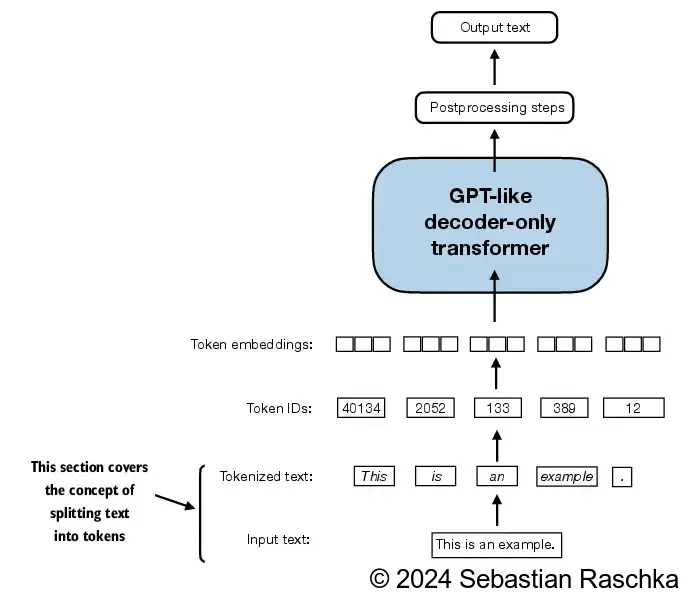  

텍스트의 출처는 Edith Wharton의 영화 `The Verdict` 입니다.

In [20]:
import os
import urllib.request

FILE_PATH = "../data/the-verdict.txt"
if not os.path.exists(FILE_PATH):
    url = ("https://raw.githubusercontent.com/rasbt/"
            "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    urllib.request.urlretrieve(url, FILE_PATH)

In [21]:
with open(FILE_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character: ", len(raw_text))
print(raw_text[:99])

Total number of character:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### 문자열을 쪼개고 숫자로 바꾸기 (토크타이징 + 임베딩) 

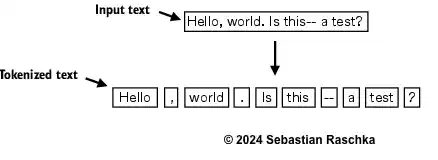

* 간단한 문장에 대해서 간단한 토크나이저 개발 + 위에서 가져온 문장에 적용

In [22]:
# 공백을 기준으로 분할하는 정규식
import re

text = "Hello, world. This, is a test."
result = re.split(r"(\s)", text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [23]:
# 공백 + 콤마 + 쉼표를 포함한 기준으로 분할하는 정규식
result = re.split(r"([,.]|\s)", text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [24]:
# 빈 문자열 및 공백을 제거
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [25]:
# 다른 문장부호를 포함한 최종 정규식
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [26]:
# 실제 텍스트를 기반으로 토큰화 진행
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [27]:
# token의 개수
print(len(preprocessed))

4690


## 토큰을 토큰 id로 변환
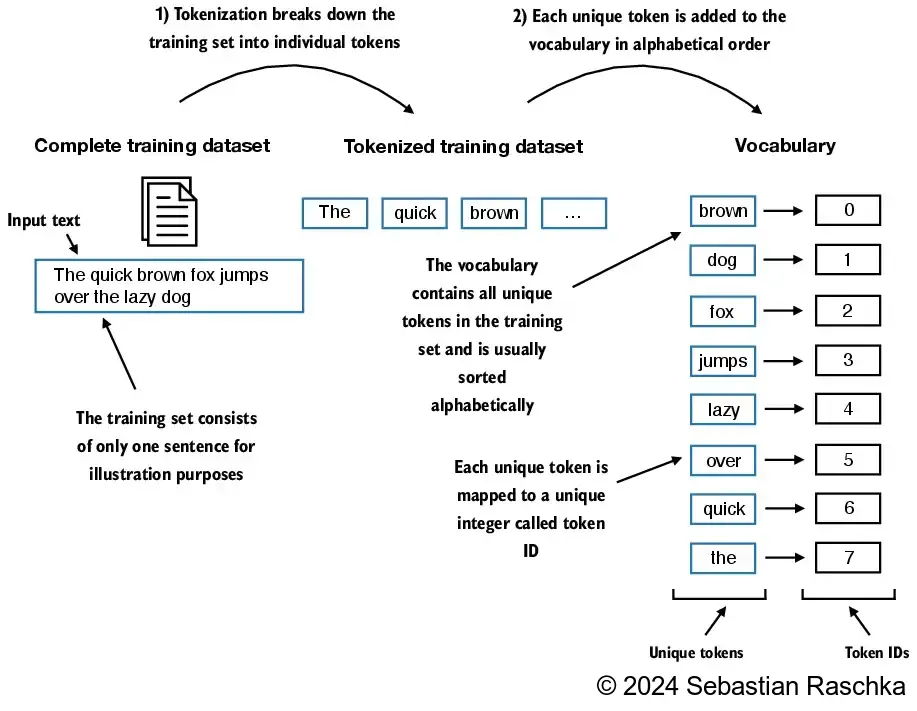

In [28]:
# 문장에 나오는 토큰들 중 중복을 제거, 어휘 사전 생성

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [29]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [30]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


아래 그림을 보면서 간단한 어휘 사전을 사용해서 영어 문장을 토크나이징 하는 방법을 알아보자

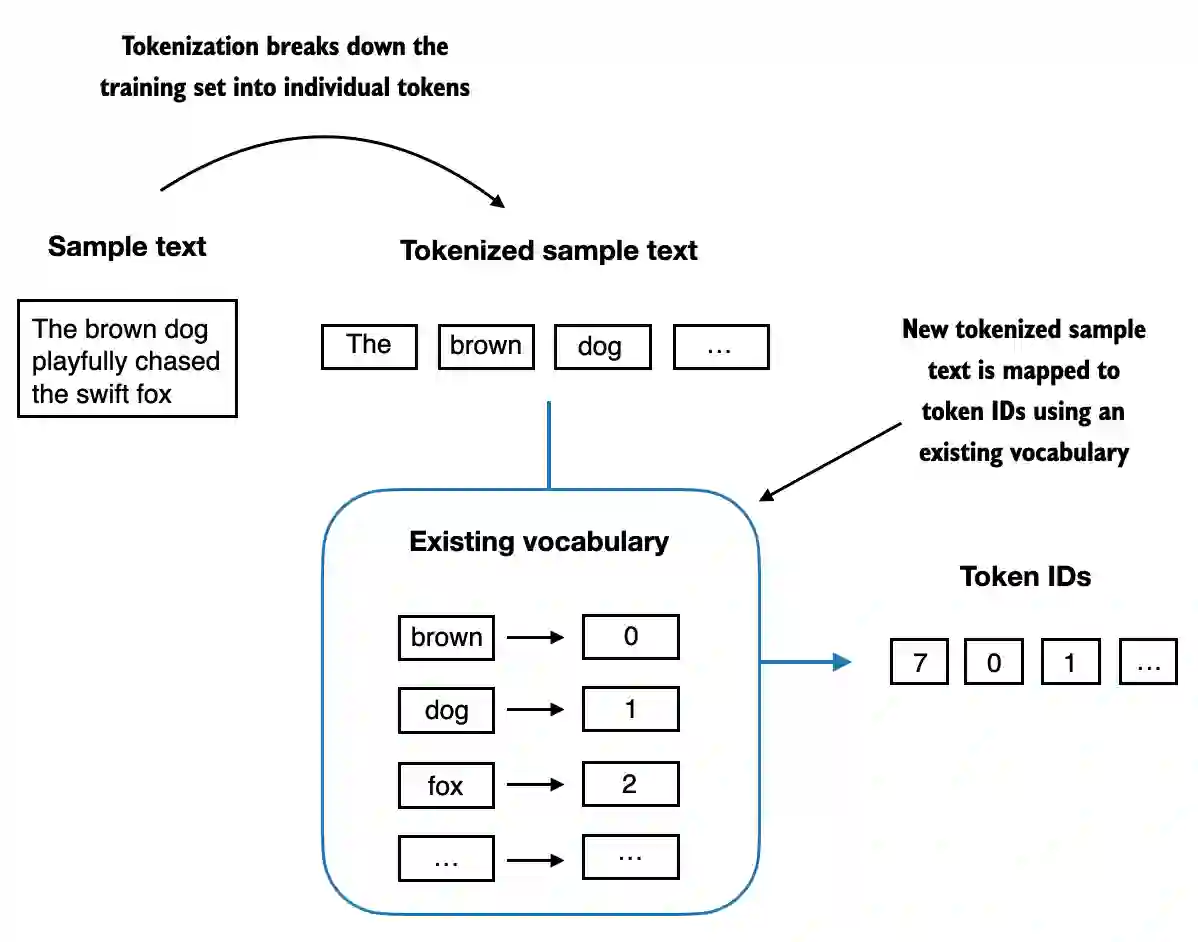
1. 영어 문장을 분절화해서 토큰으로 만들기
2. 각 토큰을 미리 정해진 어휘 사전을 사용해서 벡터로 변화
3. 그러면 토큰의 개수만큼 벡터가 나오게 되고, 이는 행렬의 형태로 나타난다.

In [31]:
# 인코딩과 디코딩을 하나의 토크나이저 클래스로 합치자
class SimpleTokenizerV1:
    def __init__(self, vocab: dict):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}
    
    def encode(self, text: str):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[id] for id in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

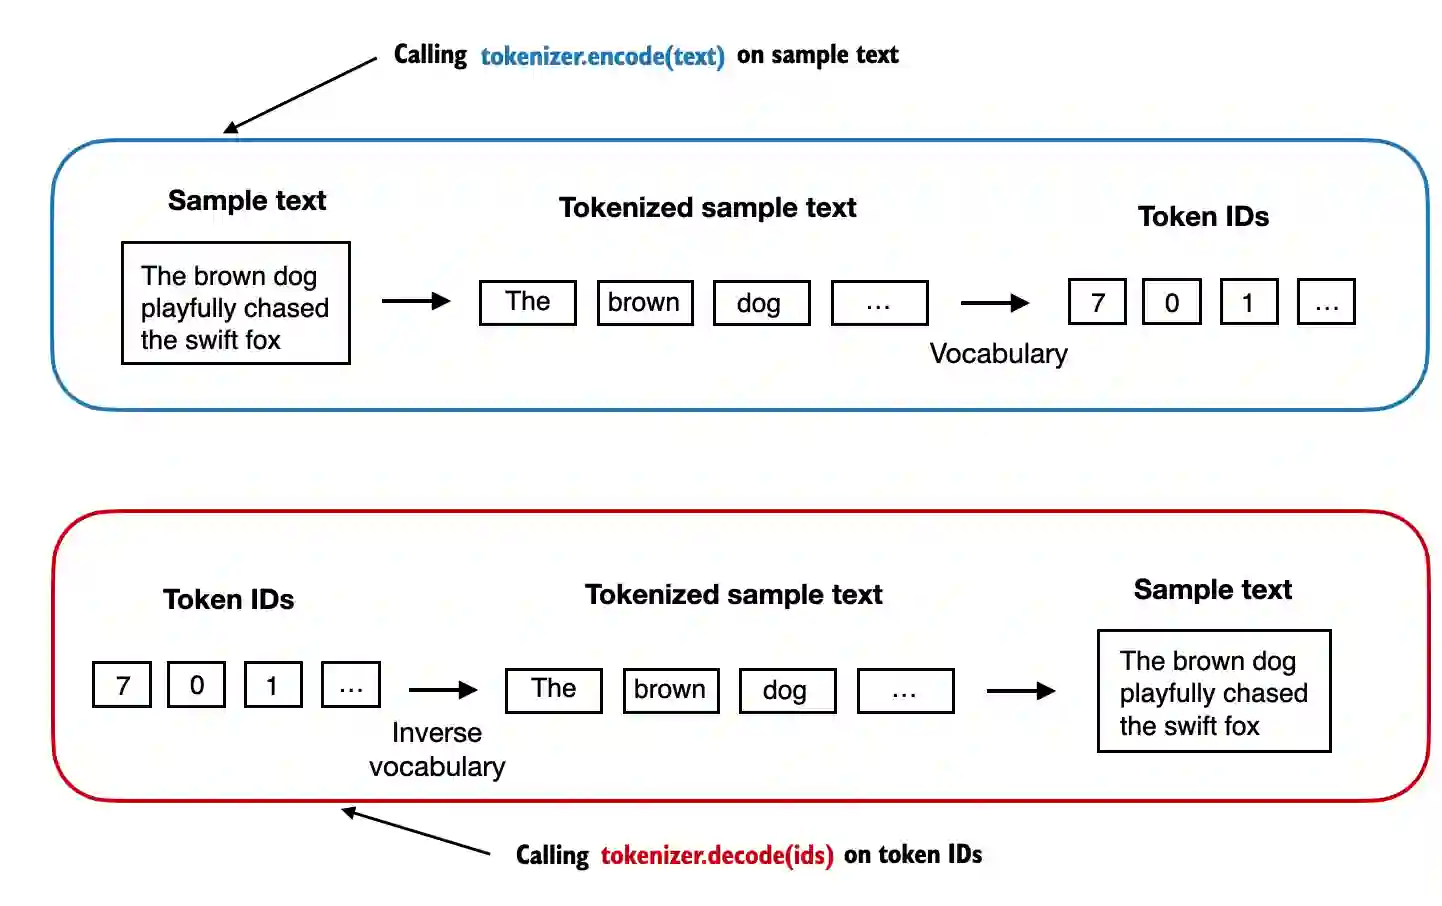
* `encode` 함수는 문자열을 토큰 id 숫자로 변환
* `decode` 함수는 토큰 id를 문자열로 변환

### decode함수 정규식 설명
`re.sub(src, dest, str)`는 str 문자열에 있는 `src` 정규식에 포함된 문자열을 `dest`로 바꾸는 함수
#### `r'\s+([,.?!"()\'])'`
* `\s+` 는 모든 space를 의미, tab, 공백 등등
* `()` 는 캡처 그룹을 의미하고 나중에 재사용 가능
* `[]` 안에 있는 문자들 중 하나만 있어도 가능

#### `\1`
* 첫번째 캡처 그룹을 의미. 여기서는 `([,.?!"()\'])` 정규식을 의미

즉 앞에 있는 공백을 제거하는 코드이며, `asdf , asdf` -> `asdf, asdf` 로 변환하는 코드이다.

In [32]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""

# 문자열을 숫자로 바꾸기
ids = tokenizer.encode(text)
print(ids)

# 숫자를 문자열로 바꾸기
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


## 특수 토큰
어휘 사전에 없는 단어를 표현하거나 문자열의 마지막을 표현하기 위해서 특수한 토큰을 추가한다.
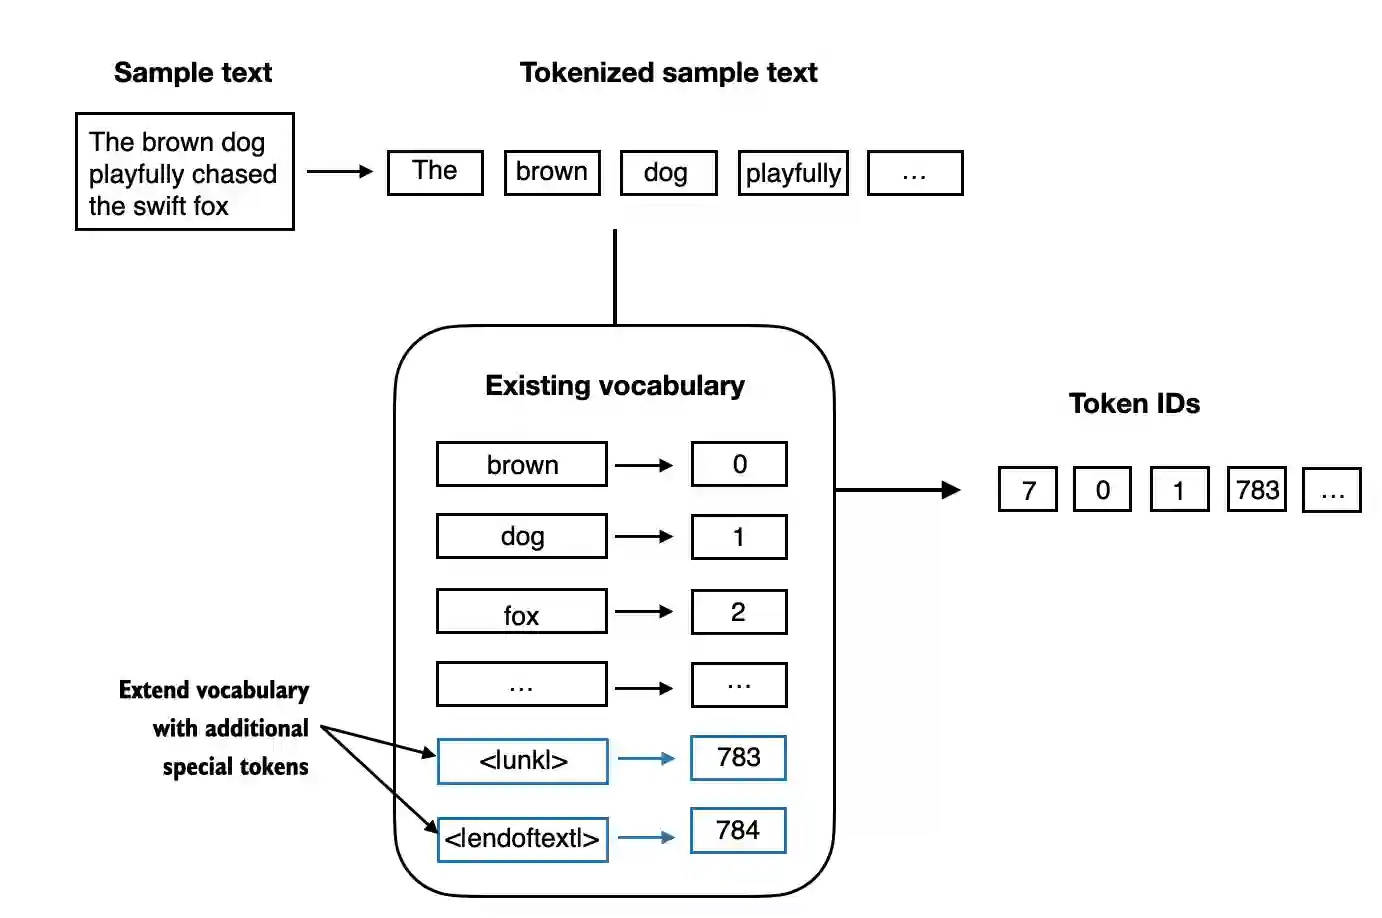
* 이런 토큰들은 LLM에게 추가 맥락을 제공하며 일반적으로 사용하는 토큰은 다음과 같다.
  * `[BOS] (beginning of sequence)`: 문자열의 시작
  * `[EOS] (end of sequence)`: 문자열의 마지막, 서로 다른 문서에서 가져온 문장을 구분하기 위해서 사용
  * `[PAD] (padding)`: LLM은 각자 정해진 context window 크기 만큼 토큰을 처리하는데 해당 크기보다 작은 문자열이 들어오면 이 토큰으로 채워서 길이를 맞춘다.
  * `[UNK] (unknown)`: 어휘사전에 없는 단어를 표현

기본적인 토큰 이외에도 각 토크나이저에 따라서 가지고있는 특징이 있다.
__GPT__ 는 위에서 언급한 토큰을 모두 사용하지 않고, `<|endoftext|>` 토큰만 사용한다. 
* 그 이유는 복잡성 감소를 위해서
* GPT에서는 이 토큰을 padding과 eos토큰 용도로 사용한다.

__GPT-2__ 에서는 BPE 토크나이저를 사용해서 `<UNK>` 토큰을 사용하지 않는다.
* BPE 토크나이저는 하나의 단어를 subword로 나눠서 토큰화를 하는 방식으로 어휘 사전에 없는 단어도 subword로 쪼개서 어떻게든 토큰화를 시키는 것이 특징이며 이후에 설명할 것이다.


이 책에서는 서로 다른 출처의 문서를 구분하기 위해서 `<endoftext>` 토큰을 사용한다.
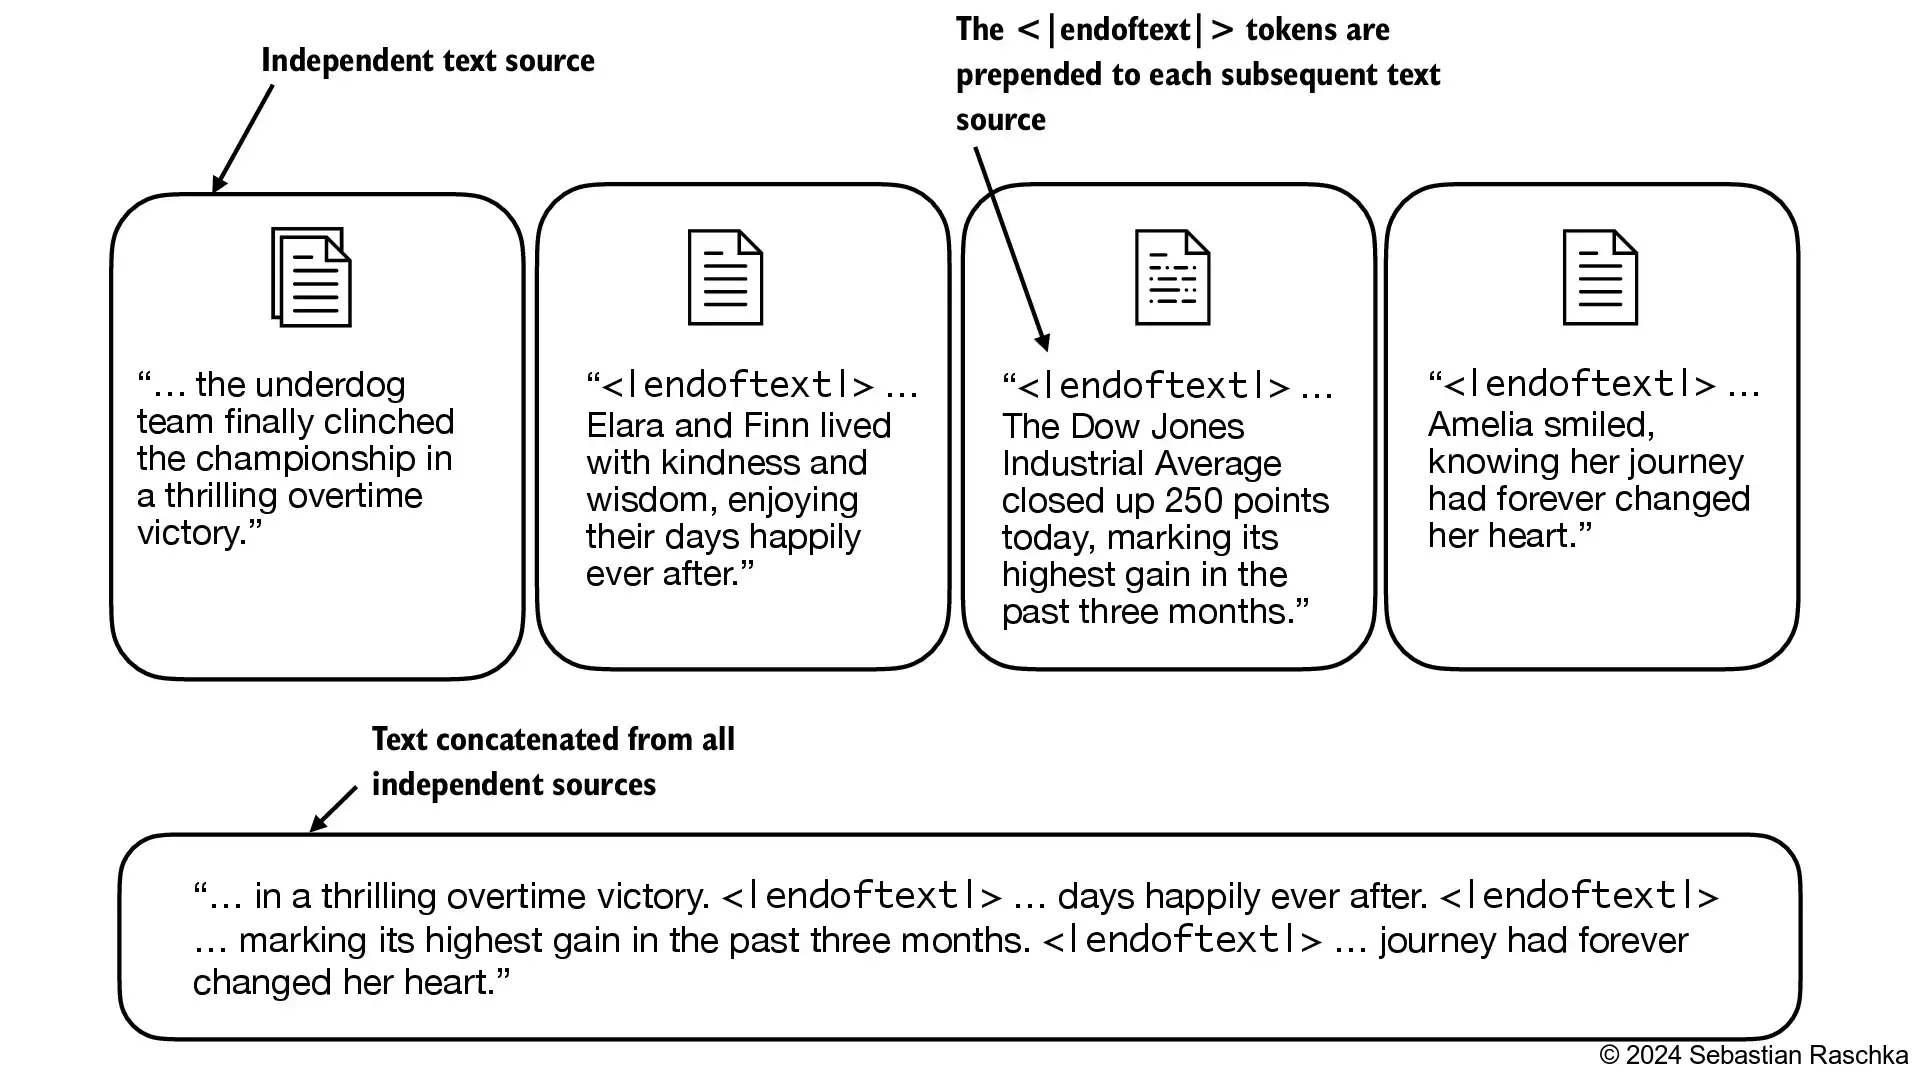


In [33]:
# 만약 기존 토크나이저에 어휘 사전 없는 단어를 넣는다면?

tokenizer = SimpleTokenizerV1(vocab)
text = "Hello, do you like tea. Is this-- a test?"
tokenizer.encode(text)

KeyError: 'Hello'

* 어휘 사전에 "Hello" 가 없기 때문에 발생한 에러
* 이런 경우를 해결하기 위해서 어휘사전에 없는 단어를 표현하는 토큰인 `<|unk|>` 를 추가
* 또한 여러 출처의 문서를 구분하기 위해서 `<|endoftext|>` 토큰을 추가. GPT-2에서 두개의 문장을 구분하거나 서로 다른 문서의 출처를 구분할때 사용.

In [34]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer, token in enumerate(all_tokens)}
len(vocab.items())

1132

In [35]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [36]:
# 이제 <unk> 를 넣어보자
class SimpleTokenizerV2:
    def __init__(self, vocab: dict):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}
    
    def encode(self, text: str):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [37]:
# 이제 새로운 토크나이저를 사용해보자
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [38]:
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## bytepair encoding

GPT-2는 토크나이저로 BPE를 사용한다.
* oov 단어를 다루기 위해서 어휘 사전에 없는 단어를 subword로 나눠 처리한다.
* 예를 들어 GPT-2가 `unfamiliarword` 라는 단어를 어휘사전에서 찾을 수 없다면 `[unfam, iliar, word]`로 나눠서 토큰화 한다.
* 실제 구현 코드는 다음에서 확인할 수 있다. https://github.com/openai/gpt-2/blob/master/src/encoder.py
* 여기서는 openai의 [titoken](https://github.com/openai/tiktoken) 라이브러리를 사용하며 이는 rust로 작성해서 성능을 올렸다.
* 추가로 bpe를 직접 구현한 노트북과 벤치마크 성능 비교 노트북을 함께 첨부하니 학습에 도움이 될것이다.

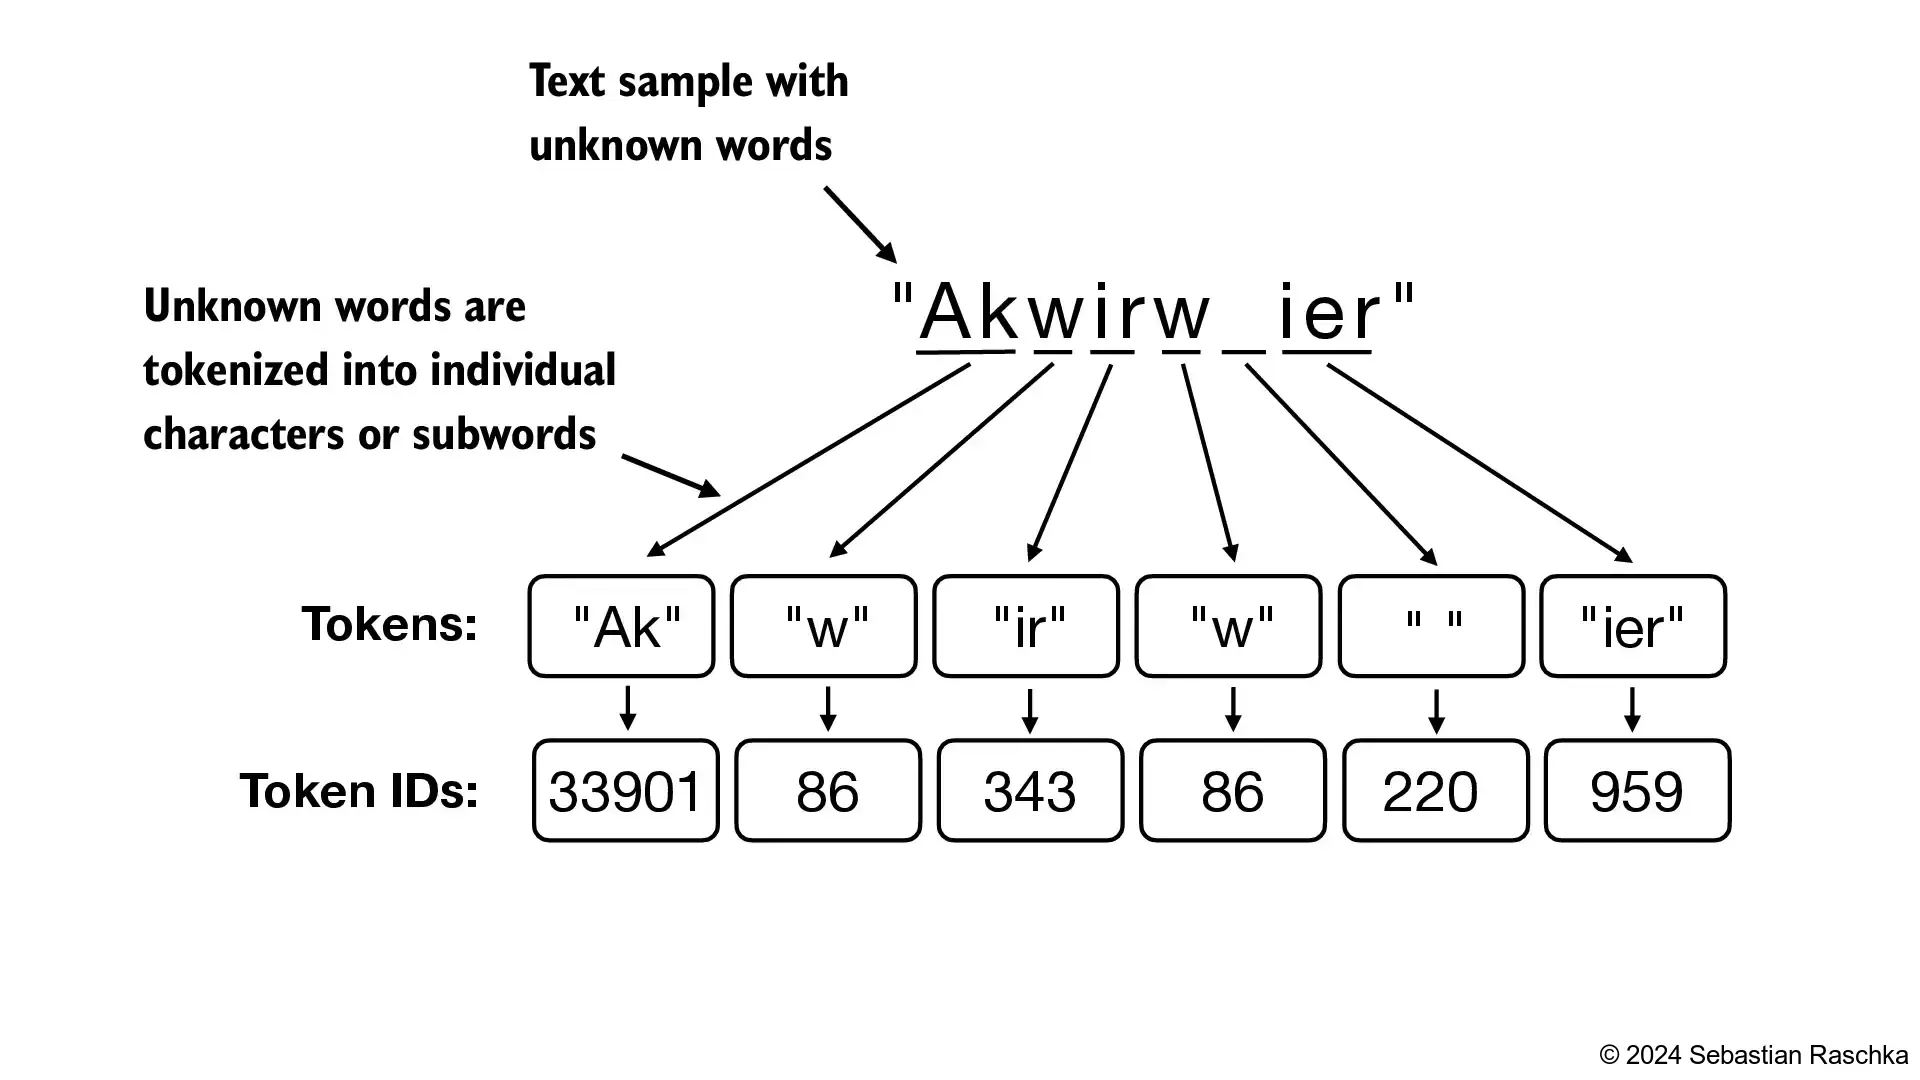

In [39]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [40]:
tokenizer = tiktoken.get_encoding("gpt2")

text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

strings = tokenizer.decode(integers)

print(strings)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


### 슬라이딩 윈도우로 데이터 샘플링 하기
* LLM이 단어를 한번에 한번씩 생성하게 학습시키기 위해서 학습 데이터를 준비하자 
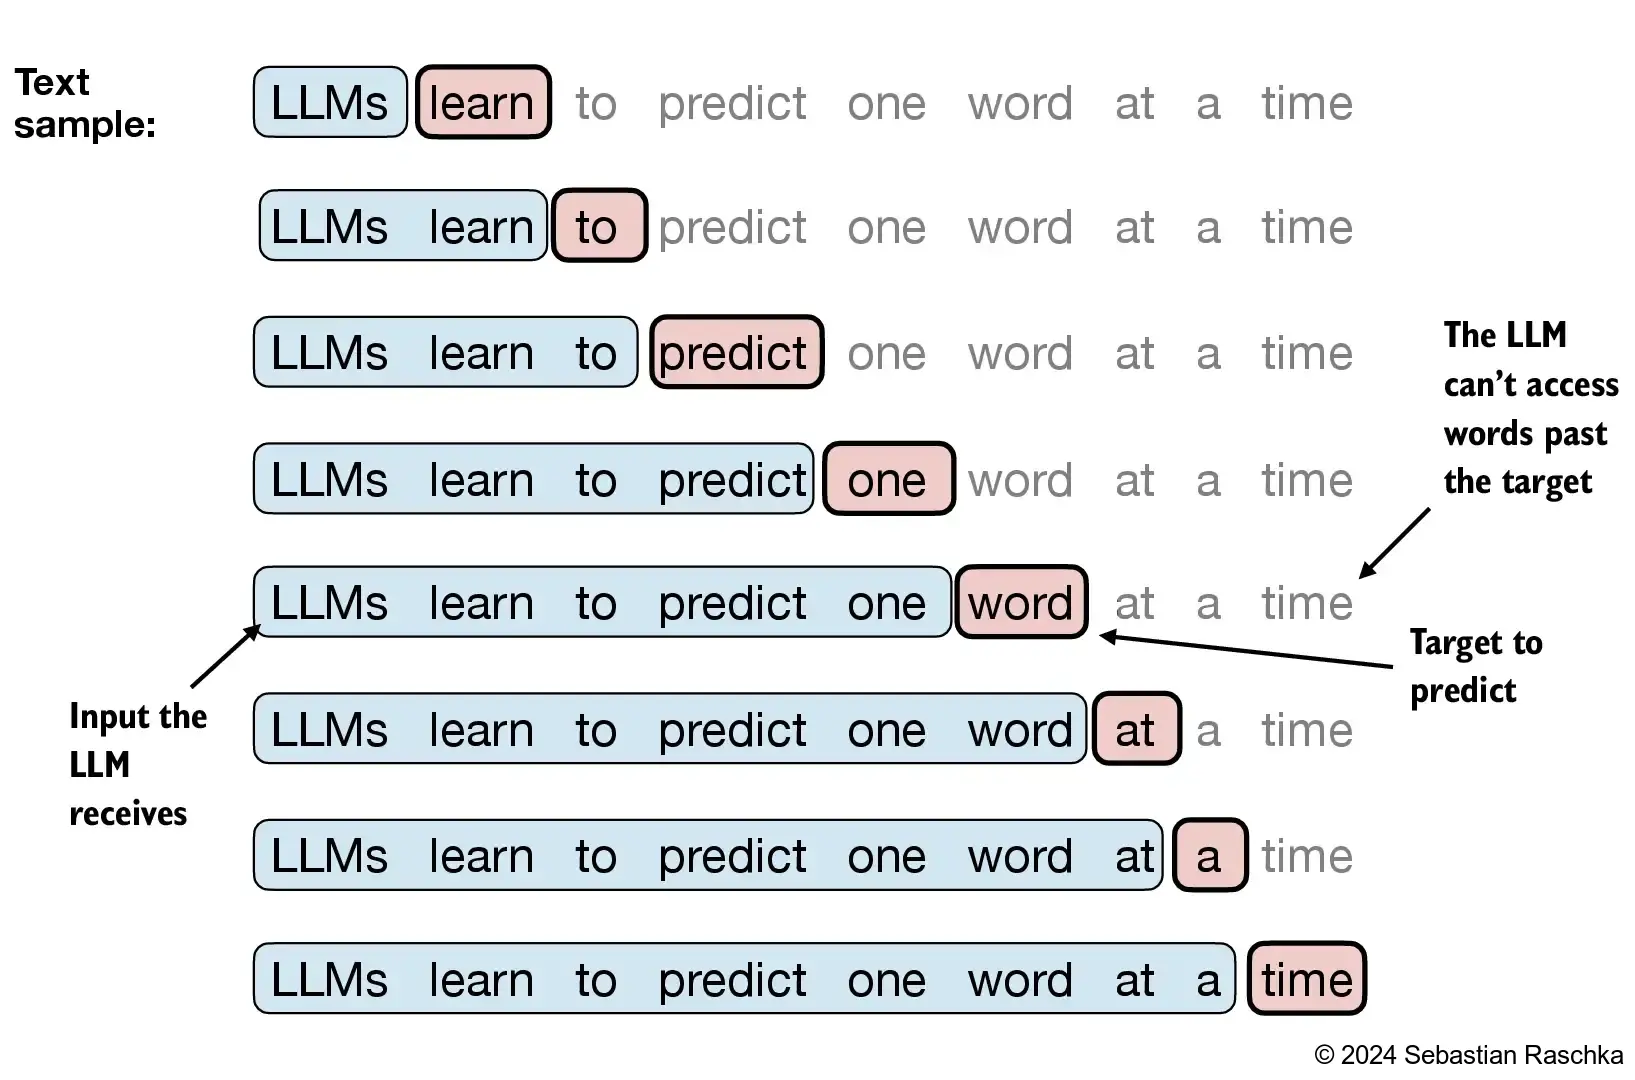

In [41]:
with open(FILE_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


* 각 텍스트 조각마다 입력값과 타겟을 지정해야함
* 왜냐하면 모델이 다음 단어를 예측하게 하기 위해서 타겟 단어를 오른쪽으로 한칸씩 이동한다.

In [42]:
enc_sample = enc_text[50:]
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [43]:
# 한번에 하나씩 보면서 예측값은 다음과 같이 볼 수 있다
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [44]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


* 다음 단어 예측은 다음 챕터인 어텐션 매커니즘에서 자세히 다룰것
* 지금은 간단한 데이터 로딩하는 것을 구현하고 있고 입력 데이터셋을 반복하면서 타겟을 옆으로 이동하고 있음

In [45]:
import torch
print("PyTorch version:", torch.__version__)

/home/sangylee/.pyenv/versions/3.12.8/envs/llm-implement/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


PyTorch version: 2.5.1+cu124


* 슬라이딩 윈도우 접근법을 사용하면 위치를 한칸씩 이동한다
* 입력 텍스트 데이터셋에서 청크를 추출하는 데이터셋 및 데이터로더 생성

In [46]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt: str, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # 전체 텍스트를 토큰화
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"
        
        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + 1 + max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [47]:
def create_dataloader_v1(
    txt, 
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0):
    
    # initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader


In [48]:
# context window를 4로 설정하고 batch 크기를 1로 한 상황에서 데이터로더를 테스트해보자

with open(FILE_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

second_batch = next(data_iter)
print(second_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


#### 예시
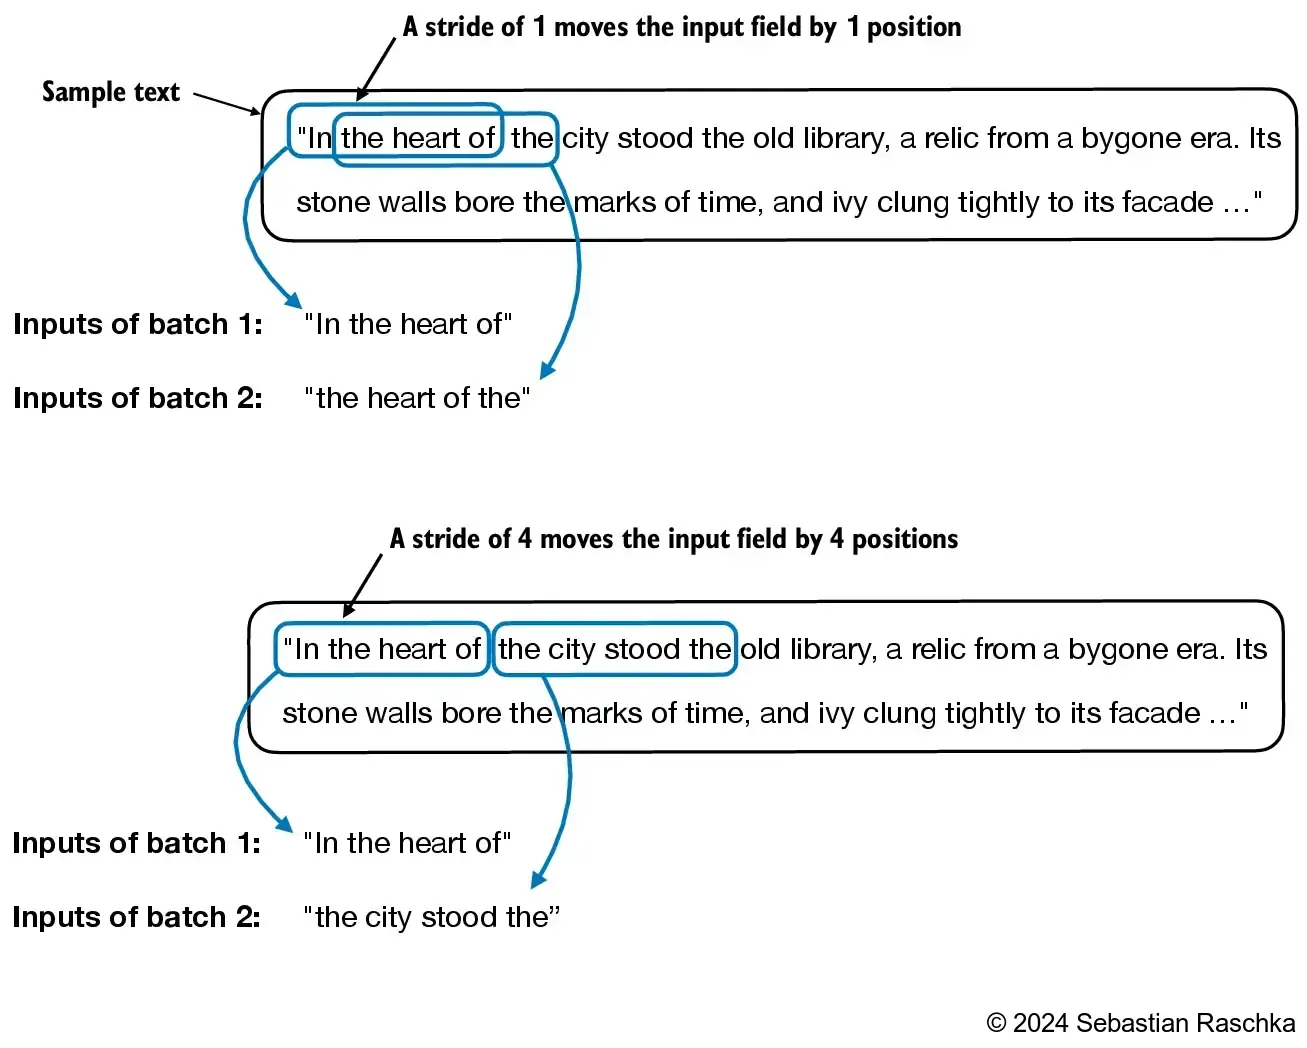
* context length와 stride 크기가 같으면 생기는 예시


그리고 이후에는 배치화된 입력값을 생성할 것이며, 보통 배치 사이에는 토큰을 겹치게 하지 않는다. 
* 토큰을 겹치게 하지 않기 위해서 stride 값을 조정한다.
* 토큰을 겹치게 할 수록 과적합 확률이 늘어나기 때문

In [49]:
dataloader = create_dataloader_v1(
    raw_text, 
    batch_size=8, 
    max_length=4, 
    stride=4, 
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### 토큰 임베딩 생성

데이터는 이제 준비가 되었지만 LLM에 넣기 위해서는 토큰을 연속적인 벡터 공간에 매핑하는 임베딩 작업이 핖요하다.
* 그리고 이 작업은 임베딩 계층이 수행한다.

보통 이러한 임베딩 계층은 LLM의 구성요소이며 학습의 대상이다.

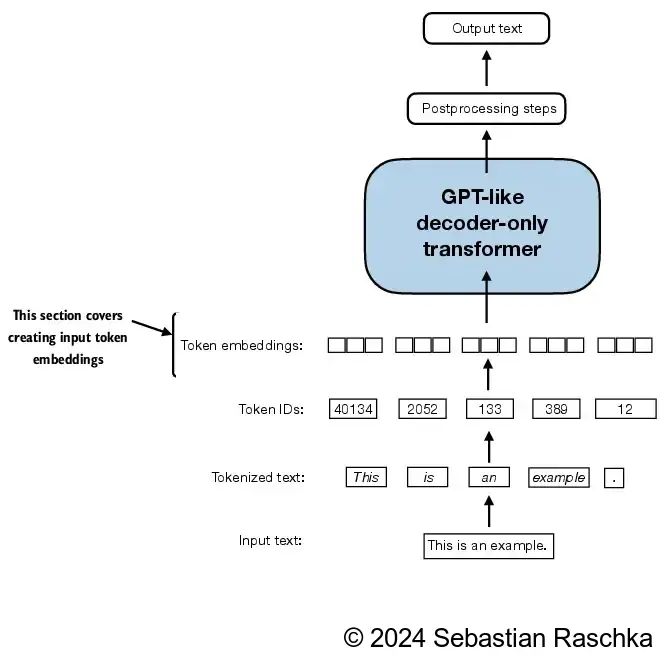

In [50]:
# 토큰의 id가 다음과 같다고 가정해보자
input_ids = torch.tensor([2, 3, 5, 1])

# 어휘 사전에 오직 6개의 단어가 있고, 벡터 크기가 3인 임베딩을 생성한다고 가정하자
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# 이 layer는 6 * 3의 가중치 행렬을 가지고 있다.
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


one-hot encoding에 익숙한 사람은 사실 위 임베딩 계층은 원핫 인코딩한 벡터를 dense한 벡터로 쉽게 만들 수 있게 하는 것이라는 점을 알 수 있다.
* 임베딩 계층과 정확히 같은 역할을 수행하는 one-hot encoding + linear 계층 행렬곱 연산보다 훨씬 효율적이다.


### 임베딩 계층과 선형 계층의 차이점 이해하기
pytorch의 임베딩 계층은 one-hot encoding + linear 계층의 행렬곱과 같은 결과를 가지며 임베딩 계층이 더욱 효율적인 연산을 가지고 있다는 것이 차이점이다.
* 다음 코드를 보면서 왜 그런지 알아보자.

#### `torch.nn.Embedding` 사용하기

In [52]:
# 이 값은 예시이며 각 숫자는 token의 id이다.
idx = torch.tensor([2, 3, 1])

# 어휘사전 크기
# 최대 숫자가 3이라면 나올 수 있는 숫자의 개수는 0, 1, 2, 3 = 4이기 때문에 어휘사전의 크기를 +1 해야한다.
num_idx = max(idx) + 1

# 벡터의 크기 (하이퍼파라미터)
out_dim = 5

torch.manual_seed(123)

embedding = torch.nn.Embedding(num_idx, out_dim)
print(embedding.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  1.5810],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015],
        [ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953]], requires_grad=True)


id가 1인 임베딩 벡터를 가져오는 방법은 다음과 같다.

그리고 다음 그림을 보면서 `torch.nn.Embedding` 의 작동원리를 알아보자.

__idx가 1인 경우__
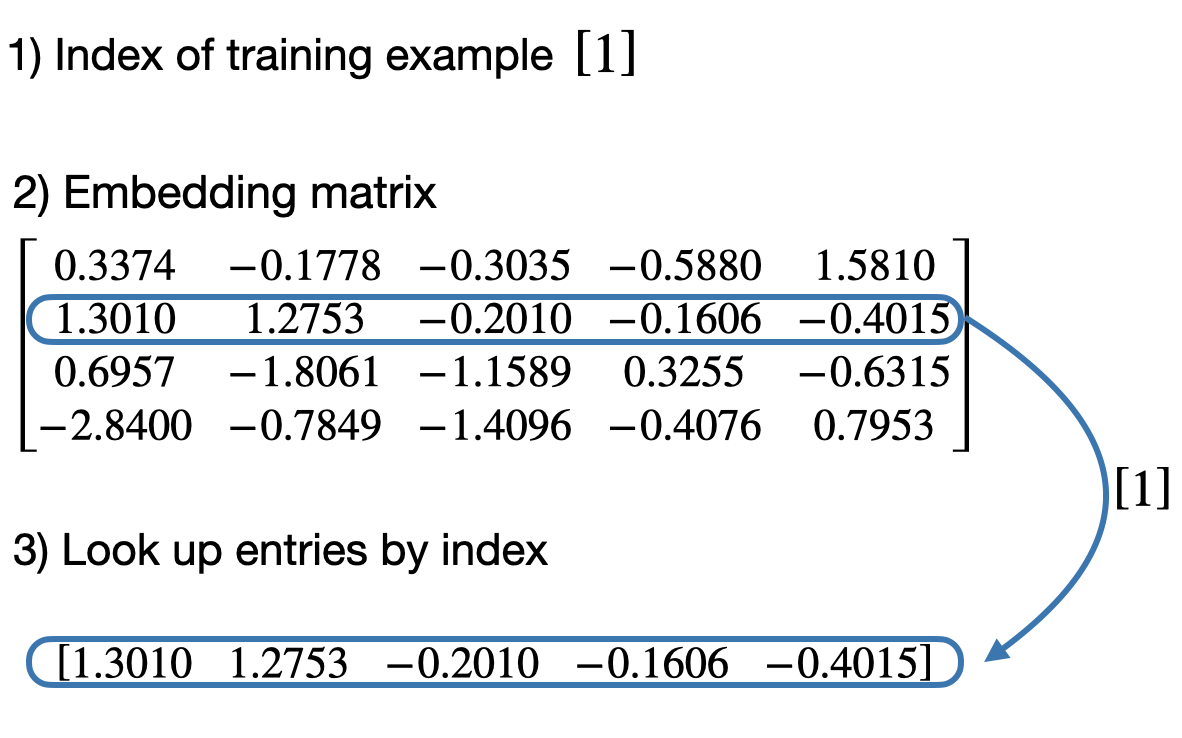


__idx가 2인 경우__
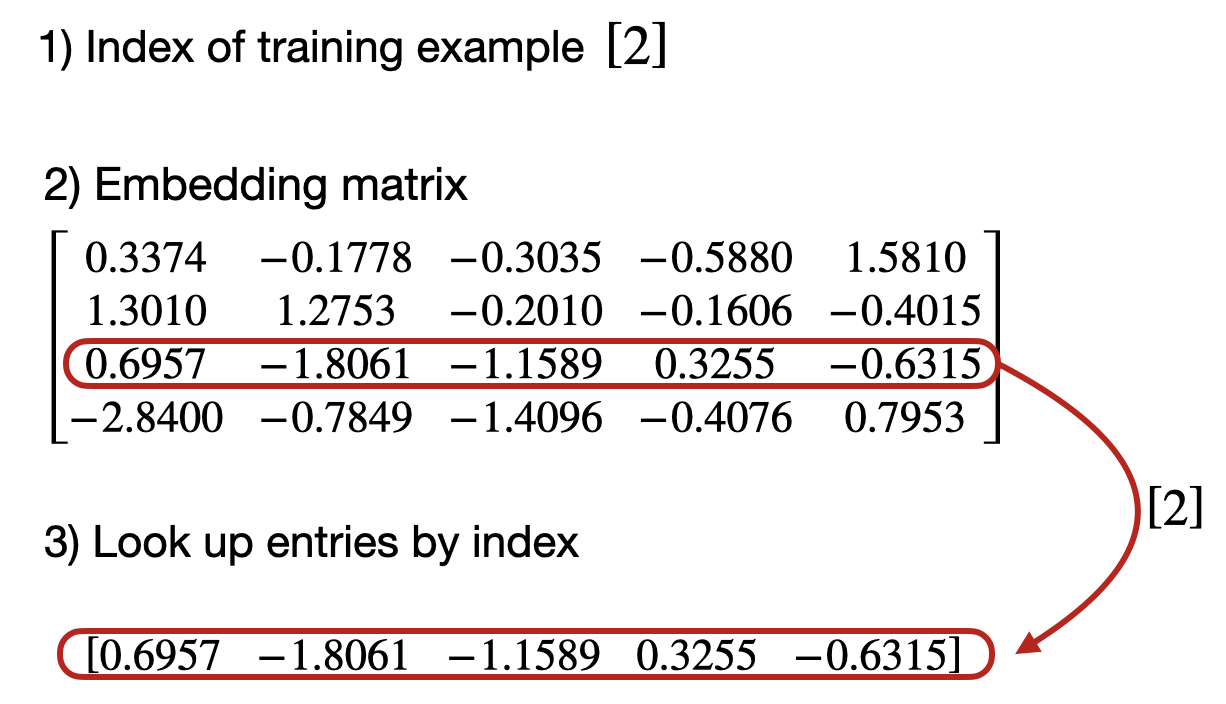

즉 embedding 계층의 n번째 행을 단순히 가져오는 방식 (0이 제일 첫번째)

In [54]:
print(embedding(torch.tensor([1])))
print(embedding(torch.tensor([2])))

tensor([[ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315]],
       grad_fn=<EmbeddingBackward0>)


그럼 한번에 묶으면? -> 행렬이 되는 것이다.
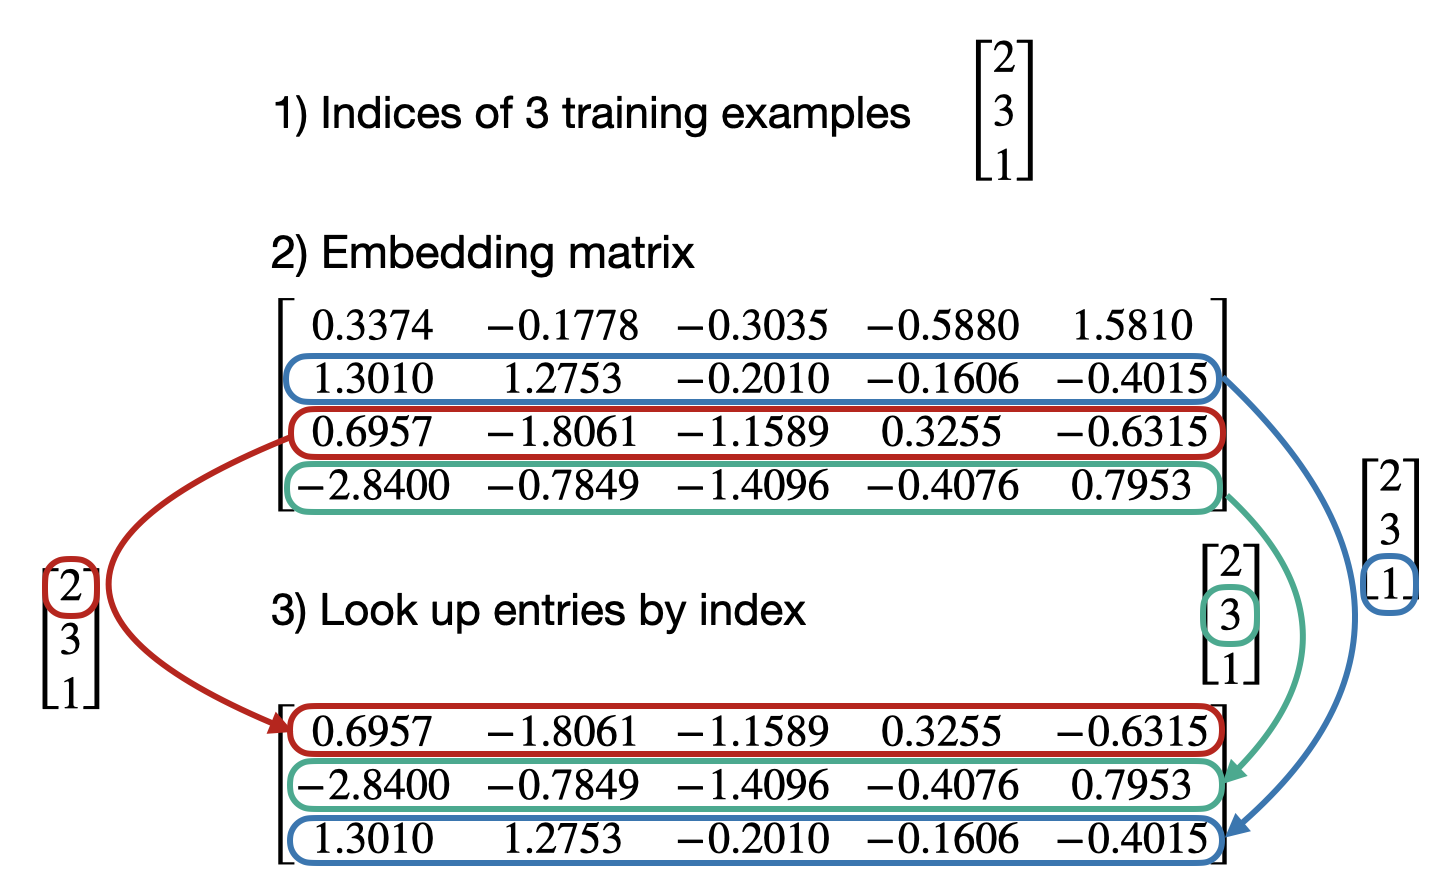

In [ ]:
idx = torch.tensor([2, 3, 1])
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

#### `torch.nn.Linear` 사용하기

이제 임베딩 계층이 `nn.Linear` + one-hot 인코딩된 계층과 같은 연산 결과를 가진다는걸 알아보자
* 일단 토큰의 id를 one-hot 표현으로 바꿔보자

In [58]:
onehot = torch.nn.functional.one_hot(idx)
onehot

tensor([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])

이제 선형 계층을 초기화하자. 이 계층은 $$XW^T$$ 행렬 곱 연산으로 나온다

즉 linear 계층의 (in_features, out_features) 형태로 선언을 한다면 실제 계층의 파라미터 행렬의 크기는 `(out_features, in_features)` 가 되는 셈.
* 그 이유는 연산할때 _전치_ 가 일어나기 때문

[torch.nn.Linear 공식문서](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

> weight (torch.Tensor) – the learnable weights of the module of shape (out_features,in_features).

In [66]:
torch.manual_seed(123)
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight

Parameter containing:
tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
        [-0.4260,  0.3665, -0.3634, -0.3975],
        [-0.3159,  0.2264, -0.1847,  0.1871],
        [-0.4244, -0.3034, -0.1836, -0.0983],
        [-0.3814,  0.3274, -0.1179,  0.1605]], requires_grad=True)

In [70]:
# 위에서 언급했듯이 torch.nn.linear는 전치를 염두에 두고 설계되었기 때문에 전치를 수행한 가중치를 가져와보자
linear.weight = torch.nn.Parameter(embedding.weight.T)

# 이제 onehot 인코딩된 값에 linear 계층을 태워보자
linear(onehot.float())

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]], grad_fn=<MmBackward0>)

이 값과 위에서 사용했던 embedding 계층의 값이 동일하다.

In [72]:
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

다음 그림을 보면서 작동 원리를 알아보자
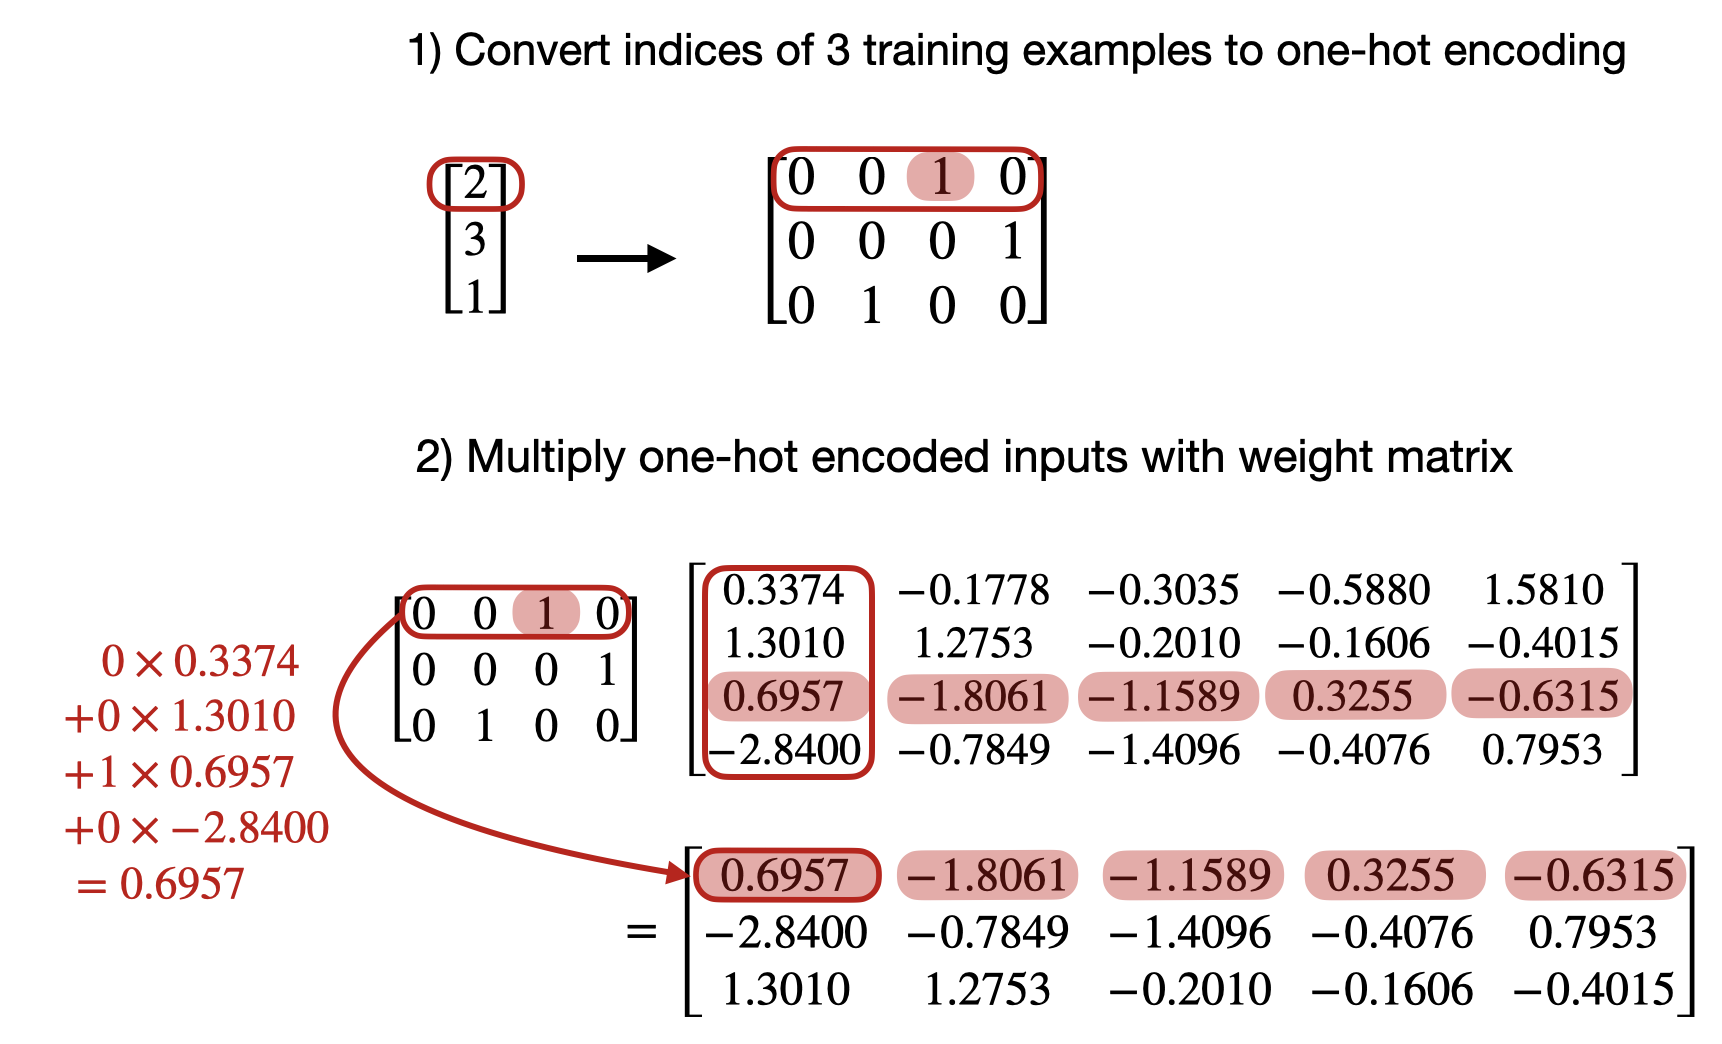
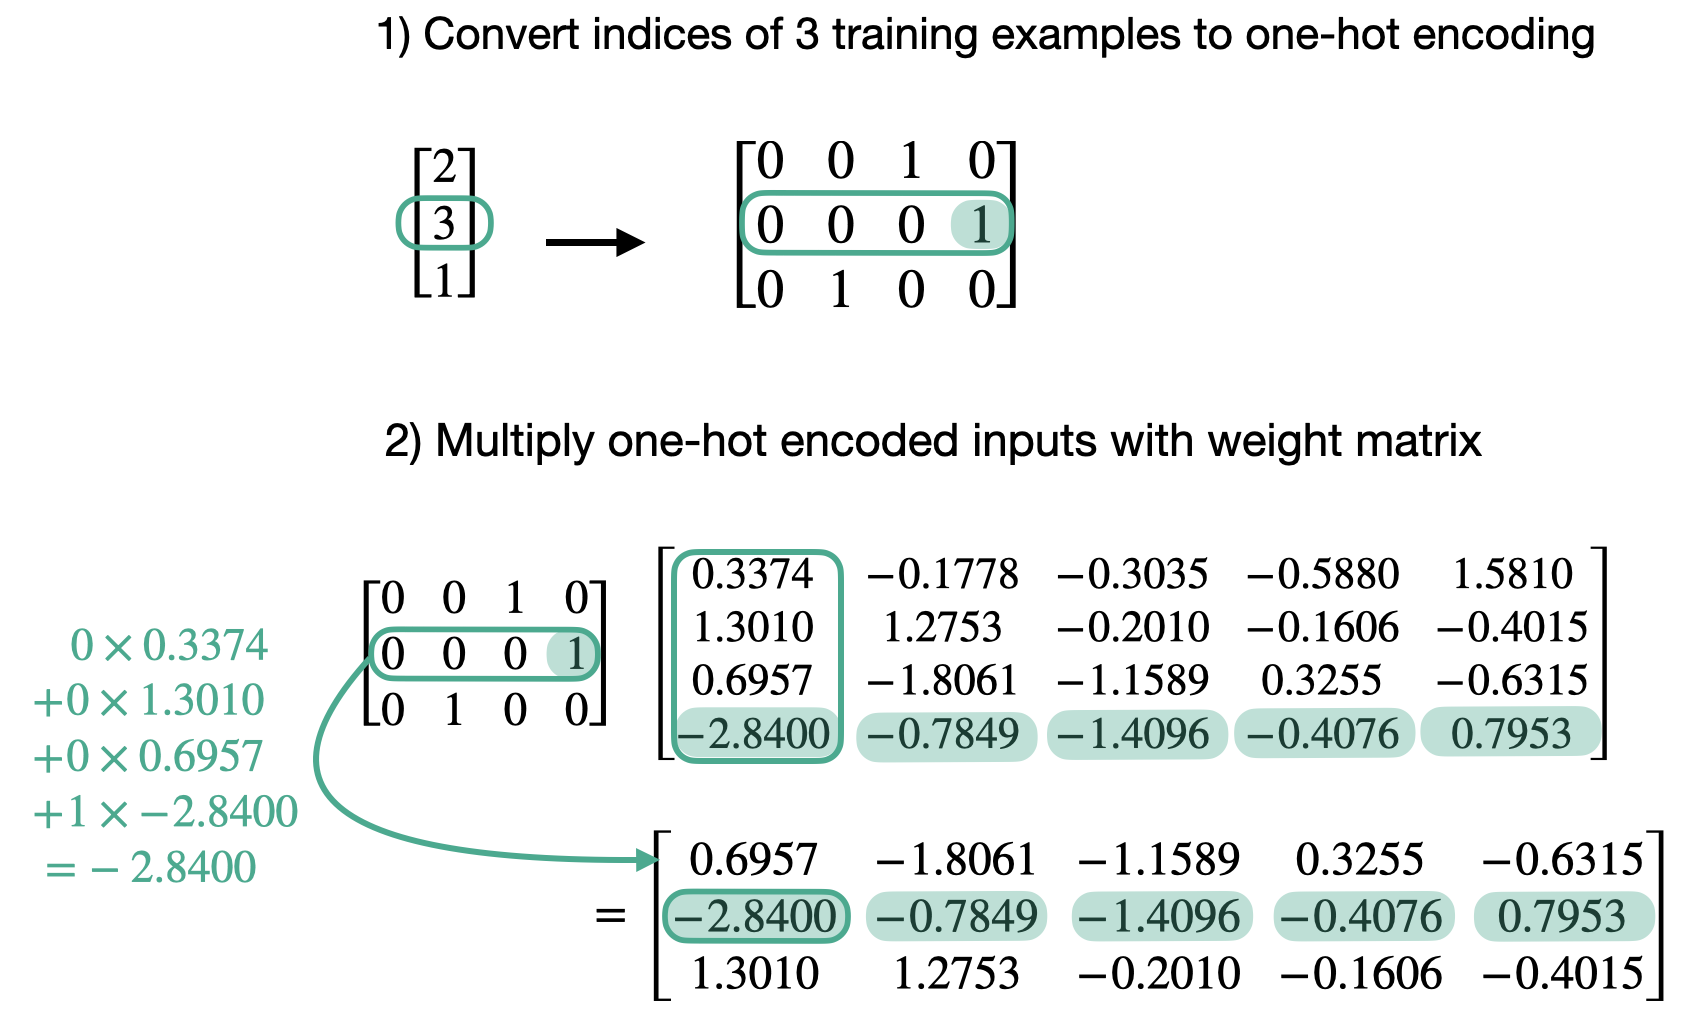

핵심 원리는 embedding 계층과 동일하다. 
* one-hot 인코딩할때 가지고 있는 1의 index에 해당하는 linear 계층의 column 값을 가져오는 방식
* 하지만 이게 더 embedding에 비해 비효율적인 이유는 추가 행렬곱 연산이 필요한점
* 0을 곱하는 쓸데없는 연산을 계속 수행하는 방식이기 때문에 행렬의 크기가 매우 커지면 연산면에서 손해가 발생한다.

### 단어의 위치를 인코딩하기
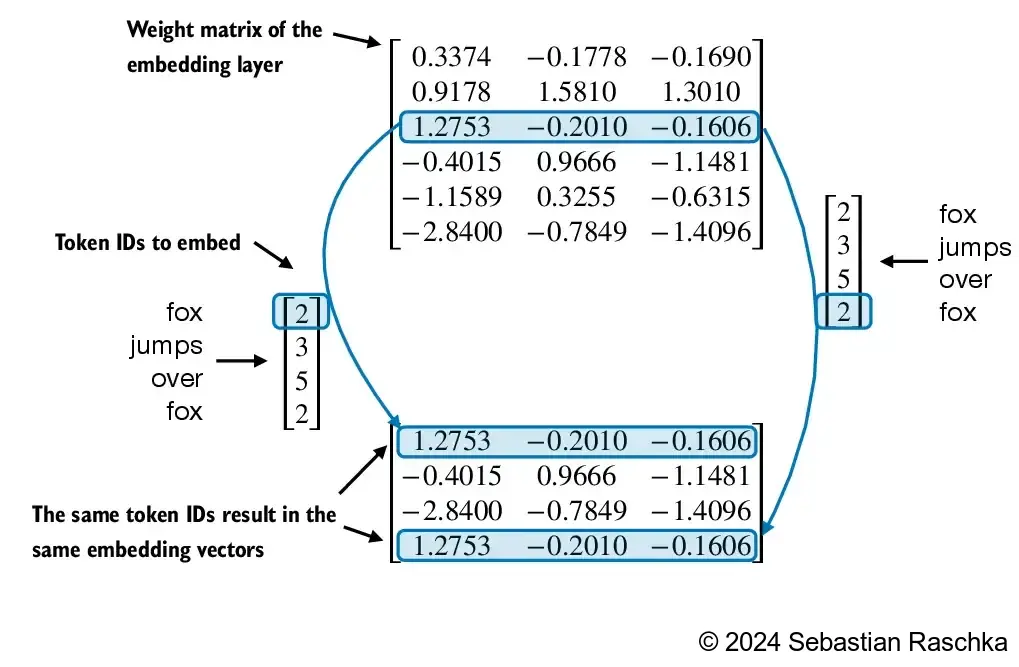
이런 임베딩 방식의 문제점은 무엇일까? 단어의 위치에 상관없이 단어 (id) 값이 같으면 항상 같은 벡터를 준다는 점이다.
* fox jumps over fox 라는 문장이 있을때 첫번째 fox랑 두번째 fox랑은 같은 벡터 값을 가짐

하지만 문장에서 단어의 위치는 문맥을 파악하는 중요한 정보이기 때문에 단어의 위치를 보정하는 방법이 필요하다.

그래서 등장한 방식이 위치 임베딩 (positional embedding)이다.
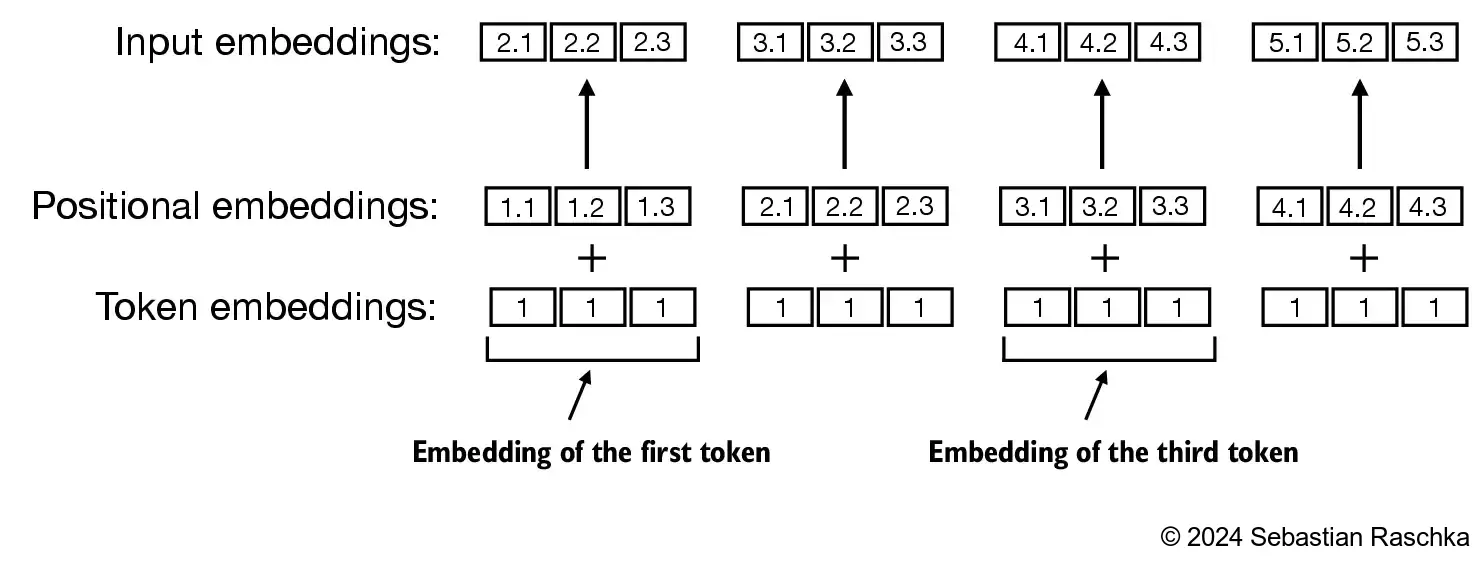
* 토큰 임베딩에 위치에 따라서 값이 변하는 위치 임베딩 값을 더해서 문장 내부에서 단어의 위치를 반영하게 한다.
* 전통적으로 삼각함수를 많이 사용했으나 요즘 최신 트랜드에서는 RoPE라고 해서 복소평면에서 벡터의 회전변환을 사용하는중

GPT-2의 bytePair encoder는 `50,257` 크기의 어휘 사전을 가지고 있다.
* 여기서는 하나의 토큰이 256 차원의 벡터 표현으로 나타낸다고 가정하자.

In [75]:
vocab_size = 50_257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

dataloader에서 데이터를 샘플링 할때 각 batch에 있는 토큰들을 256차원의 벡터로 만들게 된다. 
* 만약 batch크기가 8이며 각 batch는 4개의 토큰을 가지고 있다면 결과는 8 * 4 * 256 차원의 텐서이다.

In [78]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [80]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


GPT-2는 absolute position embeddings를 사용한다. 
* 토큰의 위치에 따라서 절대적인 고윳값을 사용하는 방식
* 그렇기 때문에 또 다른 embedding 계층을 사용하자
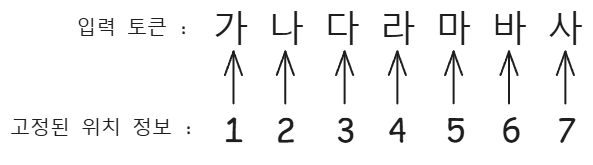

In [84]:
context_length = max_length
# 4 * 256 차원의 행렬 생성, 그 이유는 1개의 배치는 4개의 토큰이 있고 각 토큰은 256 차원의 벡터를 가지고 있기 때문
# 각 배치에는 같은 positional embedding 을 사용해야 하기 때문에 4 * 256 차원의 행렬이 필요
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

# torch.arange(4) = tensor([0, 1, 2, 3]) -> 즉 각 max_length에 맞는 위치 임베딩 벡터를 생성한것
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


LLM에서 사용하는 input embedding을 생성하기 위해서는? 단순히 토큰 임베딩 벡터와 위치 임베딩 벡터를 더하면 된다

In [86]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


이 과정을 통해서 입력 문장은 토큰으로 나뉘어졌고, 각 토큰은 미리 정의된 어휘 사전에 맞는 id로 바뀌었으며, 각 id는 벡터로 바뀌었다.

이제는 이 값을 넣어서 어떻게 llm이 처리하는지 알아보자.

* 참고로 BPE 토크나이저를 처음부터 구현하는 작업도 수행해보면 좋을듯

참고자료

[main code](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/ch02.ipynb)